In [1]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy accelerate smalldiffusion tqdm diffusers transformers xformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/88/c9/2b2e822d871b06605363e52555be5d7ff0996f4eeaf0f7e5fda15adedfbe/diffusers-0.32.2-py3-none-any.whl.metadata
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/20/37/1f29af63e9c30156a3ed6ebc2754077016577c094f31de7b2631e5d379eb/transformers-4.49.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 29.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of out

In [5]:
import torch
import numpy as np
import torchvision.transforms.v2.functional as TF
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn
from torchvision.utils import save_image, make_grid
from smalldiffusion import ModelMixin, ScheduleLDM
from collections import namedtuple
from itertools import pairwise
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

# Introduction
In this exercise you will implement a custom sampler for a pretrained text-to-image diffusion model (Stable Diffusion 2.1). The goal is to modify classifier-free guidance during the sampling process to:

  1. Generate a series of images that interpolates between two different text prompts
  2. Generate visual illusions -- images that match different text prompts when viewed from different orientations

Stable Diffusion is a [latent diffusion model](https://arxiv.org/abs/2112.10752), where the diffusion process (with a 2D-Unet denoiser model) occurs in a (4x64x64)-dimensional latent space, guided by a text embedding from a pretrained [CLIP model](https://arxiv.org/abs/2103.00020) and tokenizer. The diffusion output in latent-space is decoded into a (3x512x512)-dimeisional pixel-space image with a pretrained variational autoencoder (VAE).

First we define a wrapper class for all of these models, which will handle the text encoding and VAE decoding after the diffusion process. We also load the model from a checkpoint.

In [6]:
def alpha_bar(sigma):
    return 1/(sigma**2+1)

def show_tensor(x):
    display(TF.to_pil_image(x))

class ModelLatentDiffusion(nn.Module, ModelMixin):
    def __init__(self, model_key, accelerator=None):
        super().__init__()
        self.accelerator = accelerator or Accelerator()
        self.vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder")
        self.unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
        self.input_dims = (self.unet.config.in_channels, self.unet.sample_size, self.unet.sample_size,)
        self.text_condition = None
        self.text_guidance_scale = None
        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        self.to(self.accelerator.device)

    def tokenize(self, prompt):
        return self.tokenizer(
            prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors='pt'
        ).input_ids.to(self.accelerator.device)

    def embed_prompt(self, prompt):
        with torch.no_grad():
            return self.text_encoder(self.tokenize(prompt))[0]

    @torch.no_grad()
    def decode_latents(self, latents):
        decoded = self.vae.decode(latents / 0.18215).sample
        normalized = (decoded.squeeze()+1)/2 # from [-1,1] to [0, 1]
        return normalized.clamp(0,1)

    def sigma_to_t(self, sigma):
        idx = torch.searchsorted(reversed(self.scheduler.alphas_cumprod.to(sigma)), alpha_bar(sigma))
        return self.scheduler.config.num_train_timesteps - 1 - idx

    def forward(self, x, sigma, cond=None):
        z = alpha_bar(sigma).sqrt() * x
        return self.unet(z, self.sigma_to_t(sigma), encoder_hidden_states=cond).sample

model = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

# Sampling with classifier-free guidance

Next, we provide a starter sampler code that implements classifier-free guidance. Given $e_0$ (embedding of the empty text prompt, or a negative prompt) and $e_1$ (embedding of the target text prompt) and a guidance scale $\gamma$, classifier-free guidance is implemented as:

$$\bar{\epsilon}_t = (1-\gamma) \epsilon(x_t, \sigma_t, e_0) + \gamma \epsilon(x_t, \sigma_t, e_1)$$

20it [00:08,  2.43it/s]


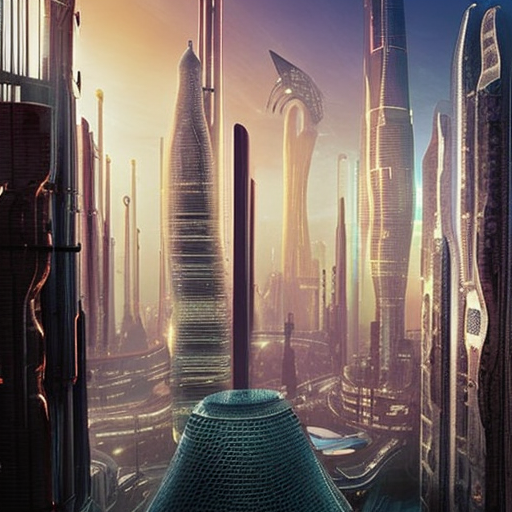

In [7]:
def sample_cfg(model,
               prompt     = 'An astronaut riding a horse',
               neg_prompt = '',
               cfg_scale  = 7.5,
               N          = 50,
               gam        = 1.,
               mu         = 0.,
               seed       = 0,):
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed text prompt and negative prompt
    embed, neg_embed = map(model.embed_prompt, (prompt, neg_prompt))

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt twice, conditioned on `prompt` and `neg_prompt` respectively
        with torch.no_grad():
            eps_pred = model.predict_eps(xt, sig.to(xt), embed)
            eps_pred_neg = model.predict_eps(xt, sig.to(xt), neg_embed)

        # Do classifier-free guidance
        eps_prev, eps = eps, (1-cfg_scale) * eps_pred_neg + cfg_scale * eps_pred

        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
    return model.decode_latents(xt)

img = sample_cfg(model,
    prompt = 'A photograph of a futuristic city',
    neg_prompt = 'low resolution',
    cfg_scale  = 7,
    gam=1.5, mu=0., N=20, seed=0,
)
show_tensor(img)

# Question 1 (3 points): Interpolation

We can modify classifier-free guidance to interpolate between two different text prompts $e_1$ and $e_2$. This is done by combining the guidance terms and varying the guidance scales $\gamma_1$ and $\gamma_2$:


$$\bar{\epsilon}_t = (1-\gamma_1-\gamma_2) \epsilon(x_t, \sigma_t, e_0) + \gamma_1 \epsilon(x_t, \sigma_t, e_1) + \gamma_2 \epsilon(x_t, \sigma_t, e_2)$$

Implement a version of `sample_cfg` that takes in multiple prompts and guidance scales and performs classifier-free guidance using the different prompts. Code to call this sampler is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [ ]:
def sample_multi_prompt(model,
                        prompts    = ['An astronaut riding a horse',
                                      'low resolution, blurry image, bad composition'],
                        cfg_scales = [7.5, -7.5],
                        N          = 50,
                        gam        = 1.,
                        mu         = 0.,
                        seed       = 0,):

    ### YOUR CODE HERE ###
    raise NotImplementedError

In [ ]:
# Modify the `sample_cfg` function above to take in multiple prompts and scales,
# enabling interpolation between two text prompts
for i, scale in enumerate(np.linspace(0, 4, 10)):
    img = sample_multi_prompt(
        model, gam=1.7, N=20, seed=7,
        prompts= ['low resolution, blurry image, bad composition',
                  'House in the woods, oil painting, ghibli inspired, high resolution',
                  'Building in a futuristic city, oil painting, ghibli inspired, high resolution',],
        cfg_scales =(-7, 2+scale, 6-scale),
    )
    show_tensor(img)

# Question 2 (3 points): Visual Illusions

We can also use classifier-free guidance to produce images that look like text prompt $e_1$ after applying transformation $t_1$ (e.g. a rotation), but also looks like text prompt $e_2$ after applying transformation $t_2$. This technique is further explored in the [visual anagrams paper](https://dangeng.github.io/visual_anagrams/); we will implement a basic version of it.


The main idea is to apply transform $t_1$ to the $x_t$ before applying classifier-free guidance conditioned on $e_1$, then applying its inverse $t_1^{-1}$ to the output. The same is done with $t_2$ and $e_2$.

$$
\begin{align*}
\bar{\epsilon}^1_t &= t_1^{-1}((1-\gamma) \epsilon(t_1(x_t), \sigma_t, e_0) + \gamma \epsilon(t_1(x_t), \sigma_t, e_1)) \\
\bar{\epsilon}^2_t &= t_2^{-1}((1-\gamma) \epsilon(t_2(x_t), \sigma_t, e_0) + \gamma \epsilon(t_2(x_t), \sigma_t, e_2))
\end{align*}
$$

The two outputs are then averaged:

$$\bar{\epsilon}_t = \frac{1}{2} (\bar{\epsilon}^1_t +\bar{\epsilon}^2_t)$$

Modify your sampler above to apply different transformations for different text prompts. Code to call this sampler to generate and display a visual illusion is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [ ]:
def sample_transforms(model,
                      prompts  = ['An astronaut riding a horse',
                                  'low resolution, blurry image, bad composition'],
                      cfg_scales = [7.5, -7.5],
                      transfomrs = None,
                      N          = 50,
                      gam        = 1.,
                      mu         = 0.,
                      seed       = 0,):

    ### YOUR CODE HERE ###
    raise NotImplementedError

In [ ]:
# Define transforms used for illusions
Transform = namedtuple('Transform', ['fwd', 'inv'])
id_t = Transform(lambda x:x, lambda x:x)
r = lambda r: lambda x: TF.rotate(x, r)
rot_180 = Transform(r(180), r(-180))

transforms = (id_t, rot_180, id_t, rot_180)

# Modify the `sample_cfg` function above to take in multiple transforms and
# apply them during classifer-free guidance
img = sample_transforms(
    model, gam=1.2, mu=0.5, N=50, seed=0,
    prompts=('', '', # Unconditional null-text prompts
            'A painting of a snowy mountain', 'A painting of a horse'),
    transforms = transforms,
    cfg_scales = (-3, -3, 3.5, 3.5),
)
imgs_t = [t.fwd(img) for t in transforms[2:]]
show_tensor(make_grid(torch.stack(imgs_t)))